## Load dependencies

In [1]:
!pip install torchtext==0.6.0

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.2/64.2 kB 1.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 18.1 MB/s eta 0:00:00
  Attempting uninstall: torchtext
    Found existing installation: torchtext 0.15.1
    Uninstalling torchtext-0.15.1:
      Successfully uninstalled torchtext-0.15.1


In [2]:
import tqdm
import spacy
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

from IPython.core.display import display, HTML

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import torchtext
from torchtext.datasets import Multi30k
from torchtext.data.metrics import bleu_score
from torchtext.data import Dataset, Example, Field, TabularDataset, BucketIterator, Iterator


In [3]:
warnings.simplefilter(action='ignore', category=UserWarning)
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=DeprecationWarning)

SEED = 546
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Device: {DEVICE}')

Device: cpu


## Load data

In [4]:
import spacy.cli 
spacy.cli.download("en_core_web_md")

✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_md')


In [5]:
import spacy.cli
spacy.cli.download("de_core_news_sm")

✔ Download and installation successful
You can now load the package via spacy.load('de_core_news_sm')


In [6]:
spacy_de = spacy.load('de_core_news_sm')
spacy_en = spacy.load('en_core_web_sm')

In [7]:
%%time
DE = Field(lower=True, tokenize='spacy', tokenizer_language='de_core_news_sm', include_lengths=True)
EN = Field(init_token='<sos>', eos_token='<eos>', lower=True, tokenize='spacy', tokenizer_language='en_core_web_md', include_lengths=True)

CPU times: user 2.94 s, sys: 413 ms, total: 3.35 s
Wall time: 3.32 s


In [8]:
train_data, valid_data, test_data = Multi30k.splits(exts=('.de', '.en'),  fields=(DE, EN))
print(f'train set size: {len(train_data.examples):,}')
print(f'valid set size: {len(valid_data.examples):,}')
print(f'test set size: {len(test_data.examples):,}')
print(vars(train_data.examples[0]))

downloading training.tar.gz


training.tar.gz: 100%|██████████| 1.21M/1.21M [00:01<00:00, 737kB/s] 


downloading validation.tar.gz


validation.tar.gz: 100%|██████████| 46.3k/46.3k [00:00<00:00, 247kB/s]


downloading mmt_task1_test2016.tar.gz


mmt_task1_test2016.tar.gz: 100%|██████████| 66.2k/66.2k [00:00<00:00, 234kB/s]


train set size: 29,000
valid set size: 1,014
test set size: 1,000
{'src': ['zwei', 'junge', 'weiße', 'männer', 'sind', 'im', 'freien', 'in', 'der', 'nähe', 'vieler', 'büsche', '.'], 'trg': ['two', 'young', ',', 'white', 'males', 'are', 'outside', 'near', 'many', 'bushes', '.']}


## Build vocabularies

In [9]:
%%time
MIN_COUNT = 2
DE.build_vocab(train_data, min_freq=MIN_COUNT, specials=['<unk>', '<pad>'])
EN.build_vocab(train_data, min_freq=MIN_COUNT, specials=['<sos>', '<eos>', '<unk>', '<pad>'])
print(f'Length of DE vocabulary: {len(DE.vocab):,}')
print(f'Length of EN vocabulary: {len(EN.vocab):,}')

Length of DE vocabulary: 7,851
Length of EN vocabulary: 5,893
CPU times: user 246 ms, sys: 1.95 ms, total: 248 ms
Wall time: 247 ms


## Modeling

**Encoder layer**

In [10]:
class EncoderLayer(nn.Module):

    def __init__(self, vocab_size, embedding_size, hidden_size, n_layers, embedding_dropout, recurrent_dropout):
        super(EncoderLayer, self).__init__()
        self.vocab_size = vocab_size
        self.embedding_size = embedding_size
        self.hidden_size = hidden_size
        self.n_layers = n_layers
        self.embedding_dropout = embedding_dropout
        self.recurrent_dropout = recurrent_dropout if n_layers > 1 else 0
        self.embedding = nn.Embedding(vocab_size, embedding_size)
        self.gru = nn.GRU(embedding_size, hidden_size, num_layers=n_layers, dropout=self.recurrent_dropout, bidirectional=True)

    def forward(self, input_sequences, sequence_lengths):
        """
        :param Tensor[seq_len, batch_size] input_sequences
        :param Tensor[batch_size,] sequence_lengths
        :return Tensor[n_layers * 2, batch_size, hidden_size] h_state
        """
        embedded = self.embedding(input_sequences)
        embedded = F.dropout(embedded, p=self.embedding_dropout)
        packed = nn.utils.rnn.pack_padded_sequence(embedded, sequence_lengths)
        _, h_state = self.gru(packed)
        return h_state

**Decoder layer**

In [11]:
class DecoderLayer(nn.Module):

    def __init__(self, vocab_size, embedding_size, hidden_size, n_layers, embedding_dropout, recurrent_dropout):
        super(DecoderLayer, self).__init__()
        self.vocab_size = vocab_size
        self.embedding_size = embedding_size
        self.hidden_size = hidden_size
        self.n_layers = n_layers
        self.embedding_dropout = embedding_dropout
        self.recurrent_dropout = recurrent_dropout if n_layers > 1 else 0
        self.embedding = nn.Embedding(vocab_size, embedding_size)
        self.gru = nn.GRU(embedding_size, hidden_size, num_layers=n_layers, dropout=self.recurrent_dropout)
        self.fc = nn.Linear(hidden_size, vocab_size)

    def forward(self, input_word_index, h_state_prev):
        """
        :param Tensor[batch_size,] input_word_index
        :param Tensor[n_layers, batch_size, hidden_size] h_state_prev
        :return Tensor[batch_size, vocab_size] logit
        :return Tensor[n_layers, batch_size, hidden_size] h_state
        """
        embedded = self.embedding(input_word_index.unsqueeze(0))
        embedded = F.dropout(embedded, p=self.embedding_dropout)
        outputs, h_state = self.gru(embedded, h_state_prev)
        logit = self.fc(outputs.squeeze(0))
        return logit, h_state

**Sequence-to-sequence model**

In [12]:
class SeqToSeqNet(nn.Module):

    def __init__(self, encoder, decoder, device):
        assert encoder.n_layers == decoder.n_layers, 'Encoder and Decoder must have the same number of reccurent layers'
        assert encoder.hidden_size == decoder.hidden_size, 'Encoder and Decoder must have the same number of reccurrent hidden units'
        super(SeqToSeqNet, self).__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.device = device
        self.init_h0 = nn.Linear(encoder.n_layers * 2, decoder.n_layers)

    def encode(self, input_sequences, sequence_lengths):
        h_state = self.encoder(input_sequences, sequence_lengths)
        h_state = self.init_h0(h_state.permute(1, 2, 0)) # [batch_size, hidden_size, n_layers]
        h_state = h_state.permute(2, 0, 1) # [n_layers, batch_size, hidden_size]
        return h_state

    def sort_batches(self, dest_sequences, dest_lengths, h_state):
        sorted_dest_lengths, sorted_indices = torch.sort(dest_lengths, dim=0, descending=True)
        sorted_dest_sequences = dest_sequences[:, sorted_indices]
        h_state = h_state[:, sorted_indices, :]
        # We won't decode at the <eos> position, since we've finished generating as soon as we generate <eos>.
        # So, decoding lengths are actual lengths - 1
        sorted_decode_lengths = (sorted_dest_lengths - 1).tolist() 
        return sorted_dest_sequences, sorted_decode_lengths, h_state

    def decode(self, h_state, sorted_dest_sequences, sorted_decode_lengths, tf_ratio):
        batch_size, last = sorted_dest_sequences.size(1), None
        logits = torch.zeros(max(sorted_decode_lengths), batch_size, self.decoder.vocab_size).to(self.device)
        for t in range(max(sorted_decode_lengths)):
            batch_size_t = sum([l > t for l in sorted_decode_lengths])
            if last is not None:
                if np.random.rand() < tf_ratio:
                    input_word_index = last[:batch_size_t] # in_ [batch_size,]
                else:
                    input_word_index = sorted_dest_sequences[t, :batch_size_t] # in_ [batch_size,]
            else:
                input_word_index = sorted_dest_sequences[t, :batch_size_t] # in_ [batch_size,]
            logit, h_state = self.decoder(input_word_index, h_state[:, :batch_size_t, :].contiguous())
            # logit: [batch_size, vocab_size] - h_state: [n_layers, batch_size, hidden_size]
            logits[t, :batch_size_t, :] = logit
            last = torch.argmax(F.softmax(logit, dim=1), dim=1) # [batch_size,]
        return logits
    
    def forward(self, src_sequences, src_lengths, dest_sequences, dest_lengths, tf_ratio):
        """
        :param Tensor[seq_len, batch_size] src_sequences
        :param Tensor[batch_size,] src_lengths
        :param Tensor[seq_len, batch_size] dest_sequences
        :param Tensor[batch_size,] dest_lengths
        :param float tf_ratio
        :return Tensor[max(decode_lengths), batch_size, vocab_size] logits
        :return Tensor[seq_len, batch_size] sorted_dest_sequences
        :return list[max(decode_lengths) - 1] sorted_decode_lengths
        """
        h_state = self.encode(src_sequences, src_lengths)
        sorted_dest_sequences, sorted_decode_lengths, h_state = self.sort_batches(dest_sequences, dest_lengths, h_state)
        logits = self.decode(h_state, sorted_dest_sequences, sorted_decode_lengths, tf_ratio)
        return logits, sorted_dest_sequences, sorted_decode_lengths

**Training routines**

In [13]:
class AverageMeter:
    
    def __init__(self):
        self.value = 0.
        self.sum = 0.
        self.count = 0
        self.average = 0.
        
    def reset(self):
        self.value = 0.
        self.sum = 0.
        self.count = 0
        self.average = 0.
        
    def update(self, value, n=1):
        self.value = value
        self.sum += value * n
        self.count += n
        self.average = self.sum / self.count

In [14]:
def accuracy(outputs, target_sequences, k=5):
    batch_size = outputs.size(1)
    _, indices = outputs.topk(k, dim=1, largest=True, sorted=True)
    correct = indices.eq(target_sequences.view(-1, 1).expand_as(indices))
    correct_total = correct.view(-1).float().sum()  # 0D tensor
    return correct_total.item() * (100.0 / batch_size)

In [15]:
class Trainer:

    def __init__(self, model, optimizer, criterion, train_iterator, valid_iterator):
        self.model = model
        self.optimizer = optimizer
        self.criterion = criterion
        self.train_iterator = train_iterator
        self.valid_iterator = valid_iterator

    def clip_gradients(self, grad_clip):
        if grad_clip is not None:
            for group in self.optimizer.param_groups:
                for param in group['params']:
                    if param.grad is not None:
                        param.grad.data.clamp_(-grad_clip, grad_clip)

    def adjust_lr(self, shrink_factor=0.9, verbose=True):
        if verbose:
            print("\nDecaying learning rate.")
        for param_group in self.optimizer.param_groups:
            param_group['lr'] = param_group['lr'] * shrink_factor
        if verbose:
            print("The new learning rate is %f\n" % (self.optimizer.param_groups[0]['lr'],))
    
    def adjust_tf(self, tf_ratio, shrink_factor=0.9, verbose=False):
        tf_ratio = tf_ratio * shrink_factor
        if verbose:
            print("The teacher forcing rate is %f\n" % (tf_ratio,))
        return tf_ratio
    
    def train_step(self, epoch, grad_clip, tf_ratio):
        loss_tracker, acc_tracker = AverageMeter(), AverageMeter()
        self.model.train()
        progress_bar = tqdm.tqdm(enumerate(self.train_iterator), total=len(self.train_iterator))
        for i, data in progress_bar:
            logits, sorted_dest_sequences, sorted_decode_lengths = self.model(*data.src, *data.trg, tf_ratio=tf_ratio)
            sorted_dest_sequences = sorted_dest_sequences[1:, :] # Since we decoded starting with <sos>, the targets are all words after <sos>, up to <eos>
            logits = nn.utils.rnn.pack_padded_sequence(logits, sorted_decode_lengths).data # Remove paddings
            sorted_dest_sequences = nn.utils.rnn.pack_padded_sequence(sorted_dest_sequences, sorted_decode_lengths).data # Remove paddings
            loss = criterion(logits, sorted_dest_sequences)
            optimizer.zero_grad()
            loss.backward()
            self.clip_gradients(grad_clip)
            optimizer.step()
            loss_tracker.update(loss.item(), sum(sorted_decode_lengths))
            acc_tracker.update(accuracy(logits, sorted_dest_sequences), sum(sorted_decode_lengths))
            loss_, ppl_, acc_ = loss_tracker.average, np.exp(loss_tracker.average), acc_tracker.average
            progress_bar.set_description(f'Epoch: {epoch+1:02d} -     loss: {loss_:.3f} -     ppl: {ppl_:.3f} -     acc: {acc_:.3f}%')
        return loss_tracker.average, np.exp(loss_tracker.average), acc_tracker.average
    
    def validate(self, epoch):
        loss_tracker, acc_tracker = AverageMeter(), AverageMeter()
        self.model.eval()
        with torch.no_grad():
            progress_bar = tqdm.tqdm(enumerate(self.valid_iterator), total=len(self.valid_iterator))
            for i, data in progress_bar:
                logits, sorted_dest_sequences, sorted_decode_lengths = self.model(*data.src, *data.trg, tf_ratio=0.)
                sorted_dest_sequences = sorted_dest_sequences[1:, :]
                logits = nn.utils.rnn.pack_padded_sequence(logits, sorted_decode_lengths).data
                sorted_dest_sequences = nn.utils.rnn.pack_padded_sequence(sorted_dest_sequences, sorted_decode_lengths).data
                loss = criterion(logits, sorted_dest_sequences)
                loss_tracker.update(loss.item(), sum(sorted_decode_lengths))
                acc_tracker.update(accuracy(logits, sorted_dest_sequences), sum(sorted_decode_lengths))
                loss_, ppl_, acc_ = loss_tracker.average, np.exp(loss_tracker.average), acc_tracker.average
                progress_bar.set_description(f'Epoch: {epoch+1:02d} - val_loss: {loss_:.3f} - val_ppl: {ppl_:.3f} - val_acc: {acc_:.3f}%')
        return loss_tracker.average, np.exp(loss_tracker.average), acc_tracker.average
    
    def train(self, n_epochs, grad_clip, tf_ratio):
        history = {'acc': [], 'loss': [], 'ppl': [], 'val_ppl': [], 'val_acc': [], 'val_loss': []}
        best_loss, last_improv = np.inf, 0
        for epoch in range(n_epochs):
            if last_improv == 4:
                print('Training Finished - The model has stopped improving since last 4 epochs')
                break
            if last_improv > 0:
                self.adjust_lr()
            loss, ppl, acc = self.train_step(epoch, grad_clip, tf_ratio)
            val_loss, val_ppl, val_acc = self.validate(epoch)
            tf_ratio = self.adjust_tf(tf_ratio)
            
            if best_loss > val_loss:
                best_loss, last_improv = val_loss, 0
                torch.save(self.model.state_dict(), 'seq2seq.pth')
            else:
                last_improv += 1
                print(f'Last improvement since epoch {epoch - last_improv + 1}')
            
            history['acc'].append(acc)
            history['ppl'].append(ppl)
            history['loss'].append(loss)
            history['val_acc'].append(val_acc)
            history['val_ppl'].append(val_ppl)
            history['val_loss'].append(val_loss)
        return history

**Train the model**

In [16]:
N_LAYERS = 2
HIDDEN_SIZE = 256
EMBED_SIZE = 300
EMBED_DROPOUT = 0.25
REC_DROPOUT = 0.25
N_EPOCHS = 10
BATCH_SIZE = 64
LR = 1e-3
GRAD_CLIP = 1.0
TF_RATIO = 1.0

In [17]:
encoder = EncoderLayer(vocab_size=len(DE.vocab), embedding_size=EMBED_SIZE, hidden_size=HIDDEN_SIZE, n_layers=N_LAYERS,
                       embedding_dropout=EMBED_DROPOUT, recurrent_dropout=REC_DROPOUT)
decoder = DecoderLayer(vocab_size=len(EN.vocab), embedding_size=EMBED_SIZE, hidden_size=HIDDEN_SIZE, n_layers=N_LAYERS,
                       embedding_dropout=EMBED_DROPOUT, recurrent_dropout=REC_DROPOUT)
seq2seq = SeqToSeqNet(encoder=encoder, decoder=decoder, device=DEVICE).to(DEVICE)
optimizer = optim.RMSprop(params=seq2seq.parameters(), lr=LR)
criterion = nn.CrossEntropyLoss()
print(f'Number of parameters of the model: {sum(p.numel() for p in seq2seq.parameters() if p.requires_grad):,}')
print(seq2seq)
train_iterator, valid_iterator, test_iterator =  BucketIterator.splits((train_data, valid_data, test_data),
                                                                       batch_size=BATCH_SIZE,
                                                                       sort_key=lambda x: len(x.src),
                                                                       sort_within_batch=True, device=DEVICE)
trainer = Trainer(model=seq2seq, optimizer=optimizer, criterion=criterion, train_iterator=train_iterator, valid_iterator=valid_iterator)

Number of parameters of the model: 8,500,815
SeqToSeqNet(
  (encoder): EncoderLayer(
    (embedding): Embedding(7851, 300)
    (gru): GRU(300, 256, num_layers=2, dropout=0.25, bidirectional=True)
  )
  (decoder): DecoderLayer(
    (embedding): Embedding(5893, 300)
    (gru): GRU(300, 256, num_layers=2, dropout=0.25)
    (fc): Linear(in_features=256, out_features=5893, bias=True)
  )
  (init_h0): Linear(in_features=4, out_features=2, bias=True)
)


In [18]:
history = trainer.train(n_epochs=N_EPOCHS, grad_clip=GRAD_CLIP, tf_ratio=TF_RATIO)

Epoch: 01 -     loss: 4.481 -     ppl: 88.298 -     acc: 7.503%: 100%|██████████| 454/454 [04:55<00:00,  1.54it/s]
Epoch: 01 - val_loss: 3.857 - val_ppl: 47.307 - val_acc: 8.643%: 100%|██████████| 16/16 [00:02<00:00,  6.10it/s]
Epoch: 02 -     loss: 3.789 -     ppl: 44.217 -     acc: 8.839%: 100%|██████████| 454/454 [04:48<00:00,  1.57it/s]
Epoch: 02 - val_loss: 3.446 - val_ppl: 31.366 - val_acc: 9.505%: 100%|██████████| 16/16 [00:03<00:00,  4.89it/s]
Epoch: 03 -     loss: 3.429 -     ppl: 30.832 -     acc: 9.522%: 100%|██████████| 454/454 [04:48<00:00,  1.57it/s]
Epoch: 03 - val_loss: 3.120 - val_ppl: 22.638 - val_acc: 10.271%: 100%|██████████| 16/16 [00:02<00:00,  5.66it/s]
Epoch: 04 -     loss: 3.151 -     ppl: 23.353 -     acc: 10.039%: 100%|██████████| 454/454 [04:39<00:00,  1.63it/s]
Epoch: 04 - val_loss: 2.968 - val_ppl: 19.457 - val_acc: 10.615%: 100%|██████████| 16/16 [00:03<00:00,  5.06it/s]
Epoch: 05 -     loss: 2.899 -     ppl: 18.161 -     acc: 10.524%: 100%|██████████| 45

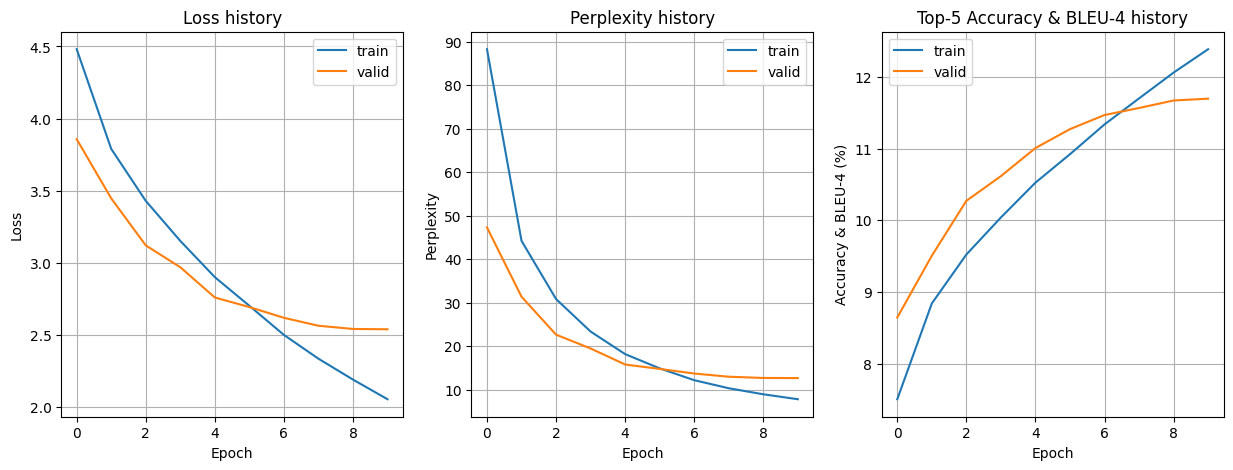

In [19]:
_, axes = plt.subplots(1, 3, figsize=(15, 5))

axes[0].plot(history['loss'], label='train')
axes[0].plot(history['val_loss'], label='valid')
axes[0].set_title('Loss history')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].grid(True)
axes[0].legend()

axes[1].plot(history['ppl'], label='train')
axes[1].plot(history['val_ppl'], label='valid')
axes[1].set_title('Perplexity history')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Perplexity')
axes[1].grid(True)
axes[1].legend()

axes[2].plot(history['acc'], label='train')
axes[2].plot(history['val_acc'], label='valid')
axes[2].set_title('Top-5 Accuracy & BLEU-4 history')
axes[2].set_xlabel('Epoch')
axes[2].set_ylabel('Accuracy & BLEU-4 (%)')
axes[2].grid(True)
axes[2].legend()

plt.show()

## Evaluation - Beam search & BLEU score

In [23]:
from beam_utils import Node, find_best_path

def evaluate(model, data, beam_size, src_field, dest_field, max_len, device):
    src_sentences = [*map(lambda example: example.src, data.examples)]
    dest_sentences = [*map(lambda example: example.trg, data.examples)]
    data = [*zip([*map(lambda word_list: src_field.process([word_list]), src_sentences)],
                 [*map(lambda word_list: dest_field.process([word_list]), dest_sentences)])]
    references, hypotheses, sources = [], [], []
    model.eval()
    with torch.no_grad():
        for i, ((src_sequence, src_length), (dest_sequence, dest_length)) in tqdm.tqdm(enumerate(data), total=len(data)):
            src_sequence, src_length = src_sequence.to(device), src_length.to(device)
            dest_sequence, dest_length = dest_sequence.to(device), dest_length.to(device)
            
            # Encoding
            h_state = model.encoder(input_sequences=src_sequence, sequence_lengths=src_length) # Encode
            h_state = model.init_h0(h_state.permute(1, 2, 0)) # [batch_size, hidden_size, n_layers]
            h_state = h_state.permute(2, 0, 1) # [n_layers, batch_size, hidden_size]

            # Decoding
            tree = [[Node(token=torch.LongTensor([dest_field.vocab.stoi[dest_field.init_token]]).to(device), states=(h_state,))]]
            for _ in range(max_len):
                next_nodes = []
                for node in tree[-1]:
                    if node.eos: # Skip eos token
                        continue
                    logit, h_state = model.decoder(input_word_index=node.token, h_state_prev=node.states[0].contiguous()) # Decode
                    # logit: [1, vocab_size]
                    # h_state: [n_layers, 1, hidden_size]
                    # c_state: [n_layers, 1, hidden_size]

                    logp = F.log_softmax(logit, dim=1).squeeze(dim=0) # [vocab_size] Get scores                    
                    topk_logps, topk_tokens = torch.topk(logp, beam_size) # Get top k tokens & logps
                    for k in range(beam_size):
                        next_nodes.append(Node(token=topk_tokens[k, None], states=(h_state,),
                                               logp=topk_logps[k, None].cpu().item(), parent=node,
                                               eos=topk_tokens[k].cpu().item() == dest_field.vocab[dest_field.eos_token]))
                if len(next_nodes) == 0:
                    break
                next_nodes = sorted(next_nodes, key=lambda node: node.logps, reverse=True) # Sort next_nodes to get the best
                tree.append(next_nodes[:beam_size]) # Update the tree
                
            best_path = find_best_path(tree) # Find the best path of the tree

            # Get the translation
            pred_translated = [*map(lambda node: dest_field.vocab.itos[node.token], best_path)]
            pred_translated = [*filter(lambda word: word not in [dest_field.init_token, dest_field.eos_token], pred_translated[::-1])]

            hypotheses.append(pred_translated) # Update hypotheses

            # Update references
            references.append([[dest_field.vocab.itos[indice] for indice in dest_sequence if indice not in (
                dest_field.vocab.stoi[dest_field.init_token],
                dest_field.vocab.stoi[dest_field.eos_token],
                dest_field.vocab.stoi[dest_field.pad_token]
            )]])

            # Update sources
            sources.append([src_field.vocab.itos[indice]  for indice in src_sequence  if indice not in (
                src_field.vocab.stoi[src_field.init_token],
                src_field.vocab.stoi[src_field.eos_token],
                src_field.vocab.stoi[src_field.pad_token]
            )])
    
        assert len(hypotheses) == len(references) == len(sources)
        bleu4 = bleu_score(hypotheses, references, max_n=4, weights=[0.25, 0.25, 0.25, 0.25]) # Calculate BLEU-4 score
    return hypotheses, references, sources, bleu4

In [24]:
seq2seq.load_state_dict(torch.load('/content/seq2seq.pth'))
seq2seq.to(DEVICE)

SeqToSeqNet(
  (encoder): EncoderLayer(
    (embedding): Embedding(7851, 300)
    (gru): GRU(300, 256, num_layers=2, dropout=0.25, bidirectional=True)
  )
  (decoder): DecoderLayer(
    (embedding): Embedding(5893, 300)
    (gru): GRU(300, 256, num_layers=2, dropout=0.25)
    (fc): Linear(in_features=256, out_features=5893, bias=True)
  )
  (init_h0): Linear(in_features=4, out_features=2, bias=True)
)

In [25]:
bleu_scores = []
for beam_size in [1, 3, 5]:
    for name, data in [('validation', valid_data), ('test', test_data)]:
        _, _, _, bleu4 = evaluate(model=seq2seq, data=data, beam_size=beam_size, src_field=DE, dest_field=EN, max_len=50, device=DEVICE)
        bleu_scores.append((beam_size, name, bleu4))
        
for bleu_score in bleu_scores:
    print(f'BLEU-4: {bleu_score[2]*100:.3f}% with beam_size={bleu_score[0]} on {bleu_score[1]} data')

100%|██████████| 1000/1000 [02:34<00:00,  6.46it/s]


BLEU-4: 21.345% with beam_size=1 on validation data
BLEU-4: 21.614% with beam_size=1 on test data
BLEU-4: 21.260% with beam_size=3 on validation data
BLEU-4: 23.202% with beam_size=3 on test data
BLEU-4: 22.327% with beam_size=5 on validation data
BLEU-4: 22.642% with beam_size=5 on test data


## Inference

In [26]:
def translate(sentences, model, beam_size, src_field, dest_field, max_len, device):
    if isinstance(sentences, list):
        sentences = [*map(src_field.preprocess, sentences)]
        targets = None
    if isinstance(sentences, Dataset):
        targets = [*map(lambda example: ' '.join(example.trg), sentences.examples)]
        sentences = [*map(lambda example: example.src, sentences.examples)]
    data = [*map(lambda word_list: src_field.process([word_list]), sentences)]
    translated_sentences, pred_logps = [], []
    model.eval()
    with torch.no_grad():
        for i, (src_sequence, src_length) in tqdm.tqdm(enumerate(data), total=len(data)):
            src_sequence, src_length = src_sequence.to(device), src_length.to(device)
            h_state = model.encoder(input_sequences=src_sequence, sequence_lengths=src_length) # Encode
            h_state = model.init_h0(h_state.permute(1, 2, 0)) # [batch_size, hidden_size, n_layers]
            h_state = h_state.permute(2, 0, 1) # [n_layers, batch_size, hidden_size]
            tree = [[Node(token=torch.LongTensor([dest_field.vocab.stoi[dest_field.init_token]]).to(device), states=(h_state,))]]
            for _ in range(max_len):
                next_nodes = []
                for node in tree[-1]:
                    if node.eos: # Skip eos token
                        continue
                    logit, h_state = model.decoder(input_word_index=node.token, h_state_prev=node.states[0].contiguous())
                    logp = F.log_softmax(logit, dim=1).squeeze(dim=0)                   
                    topk_logps, topk_tokens = torch.topk(logp, beam_size)
                    for k in range(beam_size):
                        next_nodes.append(Node(token=topk_tokens[k, None], states=(h_state,),
                                               logp=topk_logps[k, None].cpu().item(), parent=node,
                                               eos=topk_tokens[k].cpu().item() == dest_field.vocab[dest_field.eos_token]))
                if len(next_nodes) == 0:
                    break
                next_nodes = sorted(next_nodes, key=lambda node: node.logps, reverse=True)
                tree.append(next_nodes[:beam_size])
            best_path = find_best_path(tree)
            # Get the translation
            pred_translated = [*map(lambda node: dest_field.vocab.itos[node.token], best_path)]
            pred_translated = [*filter(lambda word: word not in [
                dest_field.init_token, dest_field.eos_token
            ], pred_translated[::-1])]
            translated_sentences.append(' '.join(pred_translated))
            # Get probabilities
            pred_logps.append(sum([*map(lambda node: node.logps, best_path)]))
        sentences = [*map(lambda sentence: ' '.join(sentence), sentences)]
    return sentences, translated_sentences, targets, pred_logps

In [27]:
sentences, translated_sentences, dest_sentences, pred_logps = translate(sentences=test_data, model=seq2seq, beam_size=5, src_field=DE,
                                                                        dest_field=EN, max_len=50, device=DEVICE)
indexes = np.random.choice(len(test_data.examples), size=10, replace=False)
print(indexes)
print()
for i in indexes:
    html = f'<p><span style="color:blue"><b>Source:</b> {sentences[i]}</span><br />'
    html += f'<span style="color:green"><b>Ground truth translation:</b> {dest_sentences[i]}</span><br />'
    html += f'<span style="color:red"><b>Predicted translation:</b> {translated_sentences[i]}</span></p>'
    display(HTML(html))
    print('='*100)

100%|██████████| 1000/1000 [03:41<00:00,  4.52it/s]

[565 215 894 527 263 152 630 212 509 365]



## Error Analysis

In [28]:
def get_dest_logp(model, data, src_field, dest_field, device):
    dest_logps = []
    model.eval()
    with torch.no_grad():
        for i, data in tqdm.tqdm(enumerate(data), total=len(data)):
            src_sequence, src_length = src_field.process([data.src])
            dest_sequence, dest_length = dest_field.process([data.trg])
            src_sequence, src_length = src_sequence.to(device), src_length.to(device)
            dest_sequence, dest_length = dest_sequence.to(device), dest_length.to(device)
            h_state = model.encoder(input_sequences=src_sequence, sequence_lengths=src_length)
            h_state = model.init_h0(h_state.permute(1, 2, 0))
            h_state = h_state.permute(2, 0, 1)
            logps = []
            input_word_index = torch.LongTensor([dest_field.vocab.stoi[dest_field.init_token]]).to(device)
            for idx in range(dest_sequence.shape[0]):
                logit, h_state = model.decoder(input_word_index=input_word_index, h_state_prev=h_state.contiguous())
                logp = F.log_softmax(logit, dim=1).squeeze(dim=0)
                input_word_index = dest_sequence[idx]
                logps.append(logp[input_word_index].cpu().item()) # Get logp of ground truth ouput
            dest_logps.append(sum(logps))
    return dest_logps

In [29]:
dest_logps = get_dest_logp(model=seq2seq, data=test_data, src_field=DE, dest_field=EN, device=DEVICE)
assert len(pred_logps) == len(dest_logps) == len(test_data), f'{len(pred_logps)}, {len(dest_logps)}, {len(test_data)}'

100%|██████████| 1000/1000 [00:21<00:00, 45.54it/s]


In [30]:
beam_search_faults = np.array(dest_logps) > np.array(pred_logps)

beam_search_fault_rate = beam_search_faults.sum() / beam_search_faults.size
print(f'Beam search fault rate: {beam_search_fault_rate * 100:.3f}%')
print(f'Model fault rate: {(1 - beam_search_fault_rate) * 100:.3f}%')

Beam search fault rate: 28.300%
Model fault rate: 71.700%


In [31]:
beam_search_fault_indexes = np.where(beam_search_faults == True)[0]
model_fault_indexes = np.where(beam_search_faults == False)[0]

In [32]:
for i in np.random.choice(beam_search_fault_indexes, size=5, replace=False):
    html = f'<p><span><b>Source:</b> {sentences[i]}</span><br />'
    html += f'<span style="color:green"><b>Ground truth translation:</b> {dest_sentences[i]}</span><br />'
    html += f'<span style="color:red"><b>Predicted translation (Beam search fault):</b> {translated_sentences[i]}</span><br />'
    display(HTML(html))
    print('='*100)

In [33]:
for i in np.random.choice(model_fault_indexes, size=5, replace=False):
    html = f'<p><span><b>Source:</b> {sentences[i]}</span><br />'
    html += f'<span style="color:green"><b>Ground truth translation:</b> {dest_sentences[i]}</span><br />'
    html += f'<span style="color:blue"><b>Predicted translation (Model fault):</b> {translated_sentences[i]}</span><br />'
    display(HTML(html))
    print('='*100)

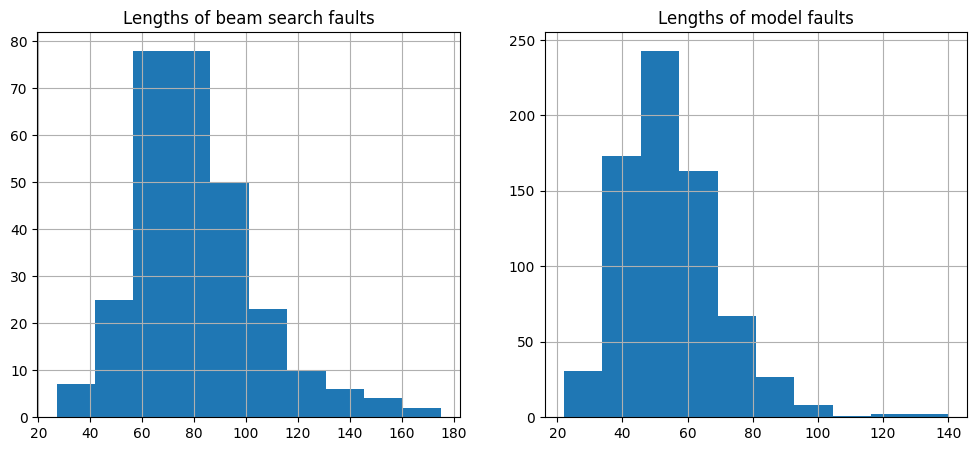

In [34]:
lengths = np.array([*map(len, dest_sentences)])

_, axes = plt.subplots(1, 2, figsize=(12, 5))
axes[0].hist(lengths[beam_search_fault_indexes])
axes[0].set_title('Lengths of beam search faults')
axes[0].grid(True)
axes[1].hist(lengths[model_fault_indexes])
axes[1].set_title('Lengths of model faults')
axes[1].grid(True)
plt.show()